In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Constants
IMG_SIZE = 128
DATA_DIR = r'leapGestRecog/leapGestRecog'

  # Change this to your dataset directory

# Function to load images
def load_images(data_dir):
    images = []
    labels = []
    for subject in os.listdir(data_dir):
        subject_dir = os.path.join(data_dir, subject)
        if os.path.isdir(subject_dir):
            for gesture in os.listdir(subject_dir):
                gesture_dir = os.path.join(subject_dir, gesture)
                for img_name in os.listdir(gesture_dir):
                    img_path = os.path.join(gesture_dir, img_name)
                    # Check if file exists
                    if not os.path.isfile(img_path):
                        print(f"File not found: {img_path}")
                        continue
                    
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    
                    # Check if image was loaded correctly
                    if img is None:
                        print(f"Failed to load image: {img_path}")
                        continue
                    
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    images.append(img)
                    labels.append(gesture)
                    
    # Convert lists to numpy arrays
    return np.array(images), np.array(labels)

# Load the data
images, labels = load_images(DATA_DIR)

# Normalize images
images = images / 255.0

# Encode labels
label_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
labels_encoded = np.array([label_dict[label] for label in labels])
labels_categorical = to_categorical(labels_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Reshape the images for CNN input
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Save preprocessed data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on the training data
datagen.fit(X_train)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train, axis=0)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the data generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=50,
                    validation_data=(X_test, y_test))

# Save the model
model.save('models/gesture_recognition_model.h5')

    

Epoch 1/50
500/500 [==============================] - 193s 383ms/step - loss: 1.3279 - accuracy: 0.5194 - val_loss: 0.2922 - val_accuracy: 0.9460
Epoch 2/50
500/500 [==============================] - 235s 470ms/step - loss: 0.5407 - accuracy: 0.8145 - val_loss: 0.1315 - val_accuracy: 0.9810
Epoch 3/50
500/500 [==============================] - 219s 437ms/step - loss: 0.3645 - accuracy: 0.8827 - val_loss: 0.0662 - val_accuracy: 0.9855
Epoch 4/50
500/500 [==============================] - 216s 431ms/step - loss: 0.2399 - accuracy: 0.9256 - val_loss: 0.0278 - val_accuracy: 0.9948
Epoch 5/50
500/500 [==============================] - 218s 436ms/step - loss: 0.1936 - accuracy: 0.9386 - val_loss: 0.0458 - val_accuracy: 0.9847
Epoch 6/50
500/500 [==============================] - 134s 267ms/step - loss: 0.1548 - accuracy: 0.9514 - val_loss: 0.0152 - val_accuracy: 0.9940
Epoch 7/50
500/500 [==============================] - 139s 278ms/step - loss: 0.1479 - accuracy: 0.9549 - val_loss: 0.0118 -

125/125 - 7s - loss: 0.0016 - accuracy: 0.9998 - 7s/epoch - 60ms/step
Test accuracy: 0.9998
Test loss: 0.0016
125/125 [==============================] - 8s 66ms/step


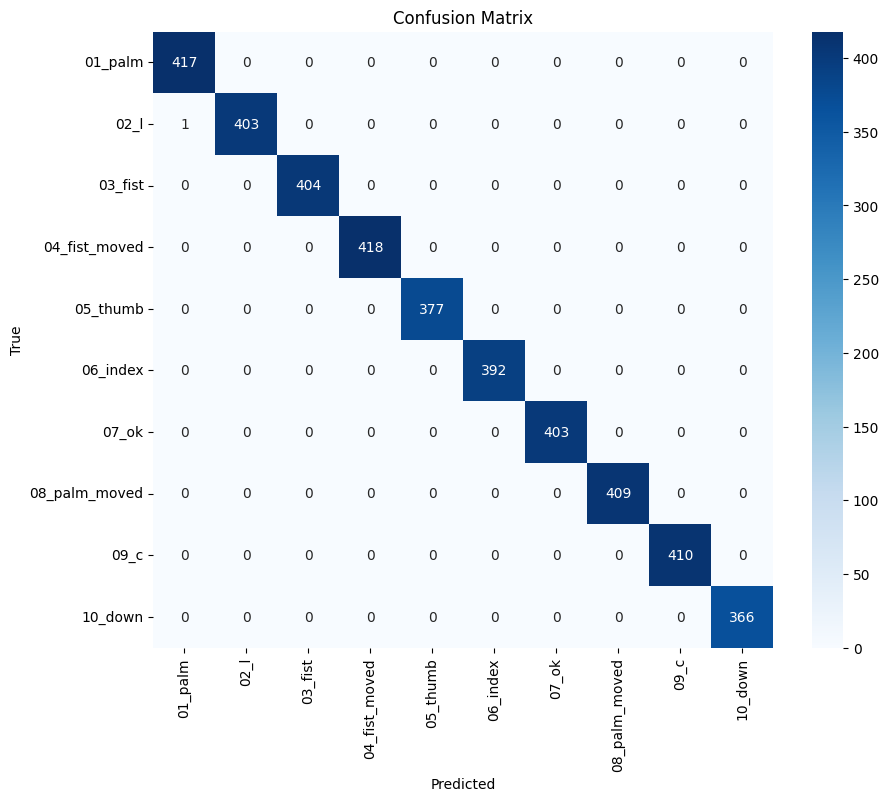

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       417
         02_l       1.00      1.00      1.00       404
      03_fist       1.00      1.00      1.00       404
04_fist_moved       1.00      1.00      1.00       418
     05_thumb       1.00      1.00      1.00       377
     06_index       1.00      1.00      1.00       392
        07_ok       1.00      1.00      1.00       403
08_palm_moved       1.00      1.00      1.00       409
         09_c       1.00      1.00      1.00       410
      10_down       1.00      1.00      1.00       366

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_dict.keys()))


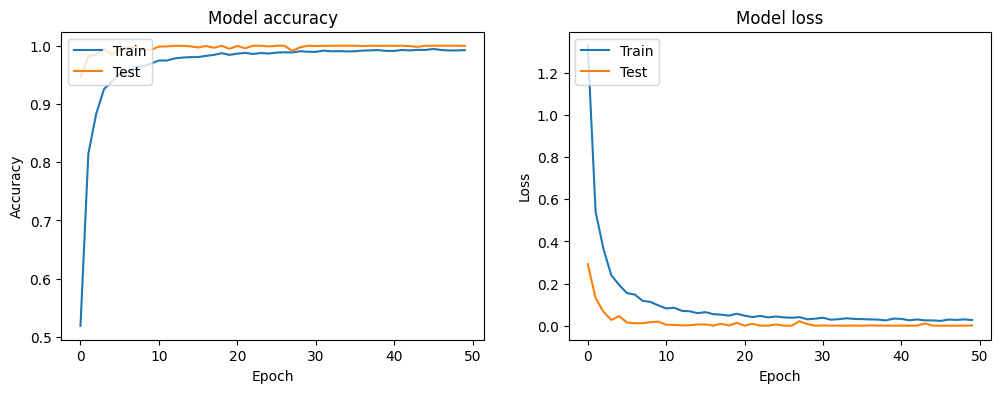

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [17]:
import cv2
import numpy as np

# Load a single image for prediction
img_path = 'C:/Users/Lamrot/Desktop/ML_4/leapGestRecog/leapGestRecog/01/01_palm/frame_01_01_0001.png'  # Replace with your image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print(f"Error: Unable to load image at {img_path}")
else:
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # Add batch and channel dimensions

    # Make prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    predicted_label = list(label_dict.keys())[predicted_class]

    print(f'Predicted Gesture: {predicted_label}')


1/1 [==============================] - 0s 70ms/step
Predicted Gesture: 01_palm
